In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import scipy.misc

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
learning_rate = 0.01
training_epoch = 20
batch_size = 100
n_hidden = 256  # the number of neurons in hidden layer

# function of put_hole
# create the hole to given images
def put_hole(images):
    
    new_images = np.zeros(images.shape)
    
    for i in range(images.shape[0]):
        img = np.copy(images[i])

        x = np.random.randint(7, high=14)
        y = np.random.randint(7, high=14)
        img[x:x + 7, y:y + 7] = 0
        new_images[i] = img
        
    return new_images

In [4]:
#TO DO: Define the placeholders X and Y for the denoising autoencoder
X = tf.placeholder(tf.float32, [None, 28, 28, 1])

In [5]:
# typically the output size of encoder is smaller than input size of encode

#TO DO: Implement the encoder of the denoising autoencoder
W1 = tf.Variable(tf.random_normal([5, 5, 1, 32], stddev=0.01))
# padding = 'SAME' keeps output size equal to input.
L1 = tf.nn.conv2d(X, W1, strides=[1, 2, 2, 1], padding='SAME')
#print(L1.shape)
L1 = tf.nn.relu(L1)
W_encode = tf.Variable(tf.random_normal([14 * 14 * 32, 256], stddev=0.01))
L2 = tf.reshape(L1, [-1, 14 * 14 * 32])
h = tf.matmul(L2, W_encode)
#print(h.shape)

In [6]:
# the output size of decoder must be the same as the input image size

#TO DO: Implement the decoder of the denoising autoencoder
output_batch = tf.shape(X)[0]
deconv_shape = tf.stack([output_batch, 28, 28, 1])
W_decode = tf.Variable(tf.random_normal([256, 14 * 14 * 32]))
L3 = tf.matmul(h, W_decode)
W3 = tf.Variable(tf.random_normal([5, 5, 1, 32]))
L3 = tf.reshape(L3, [-1, 14, 14, 32])

decoder = tf.nn.conv2d_transpose(L3, W3, 
                                 output_shape=deconv_shape,
                                 strides=[1, 2, 2, 1],
                                 padding='SAME')
decoder = tf.nn.sigmoid(decoder)

In [7]:
#TO DO: Define the cost function and optimizer
cost = tf.reduce_mean(tf.pow(X - decoder, 2))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [8]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [9]:
total_batch = int(mnist.train.num_examples / batch_size)

for epoch in range(training_epoch):
    total_cost = 0

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # Create the hole and reshape the hole_images
        hole_images = put_hole(batch_xs.reshape(-1, 28, 28, 1))

        # TO DO:Implement to train part of the denoising autoencoder
        _, cost_val = sess.run([optimizer, cost],
                               feed_dict={X: batch_xs.reshape(-1, 28, 28, 1)})
        total_cost += cost_val

    print('Epoch:', '%04d' % (epoch + 1),
          'Avg. cost =', '{:.4f}'.format(total_cost / total_batch))

Epoch: 0001 Avg. cost = 0.0230
Epoch: 0002 Avg. cost = 0.0102
Epoch: 0003 Avg. cost = 0.0048
Epoch: 0004 Avg. cost = 0.0030
Epoch: 0005 Avg. cost = 0.0021
Epoch: 0006 Avg. cost = 0.0018
Epoch: 0007 Avg. cost = 0.0017
Epoch: 0008 Avg. cost = 0.0016
Epoch: 0009 Avg. cost = 0.0017
Epoch: 0010 Avg. cost = 0.0015
Epoch: 0011 Avg. cost = 0.0016
Epoch: 0012 Avg. cost = 0.0015
Epoch: 0013 Avg. cost = 0.0015
Epoch: 0014 Avg. cost = 0.0015
Epoch: 0015 Avg. cost = 0.0015
Epoch: 0016 Avg. cost = 0.0014
Epoch: 0017 Avg. cost = 0.0014
Epoch: 0018 Avg. cost = 0.0014
Epoch: 0019 Avg. cost = 0.0014
Epoch: 0020 Avg. cost = 0.0014


Input Images


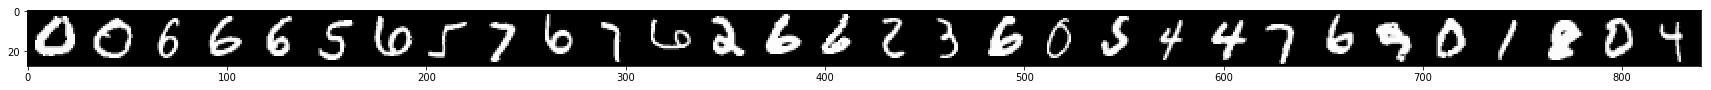

Hole Images


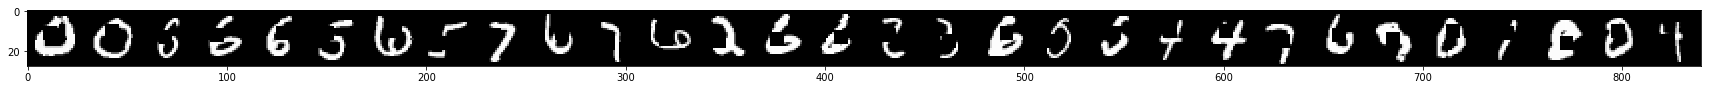

Reconstructed Images


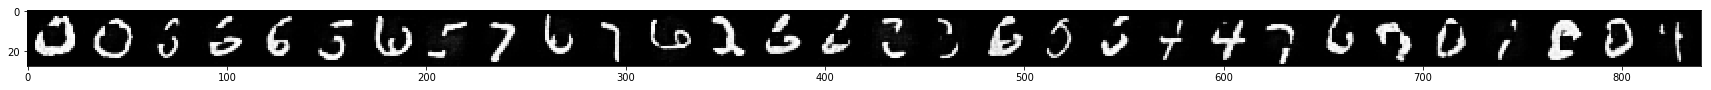

Input Images


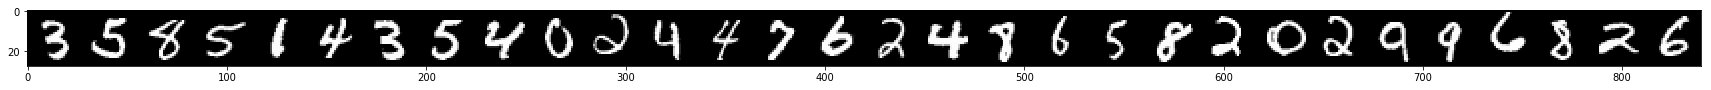

Hole Images


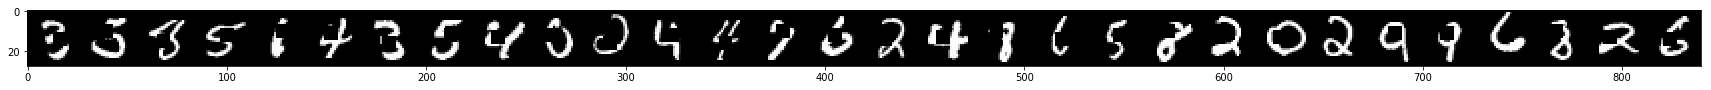

Reconstructed Images


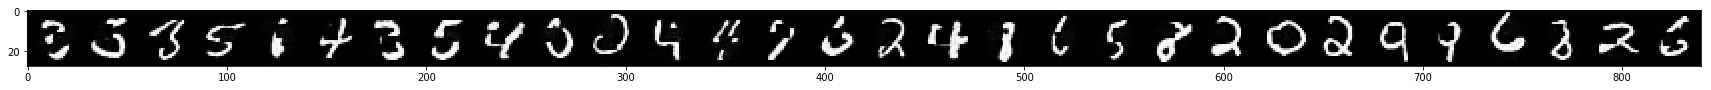

Input Images


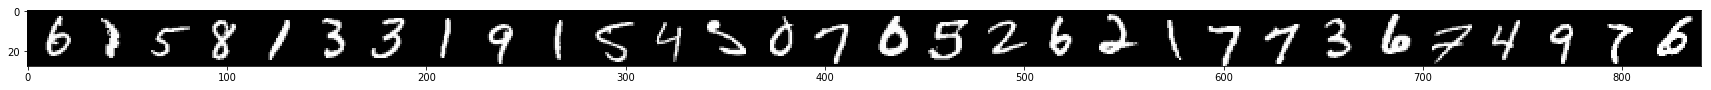

Hole Images


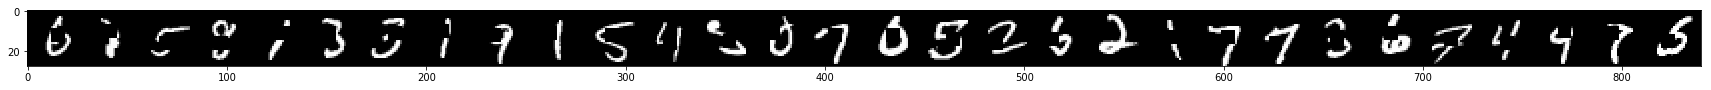

Reconstructed Images


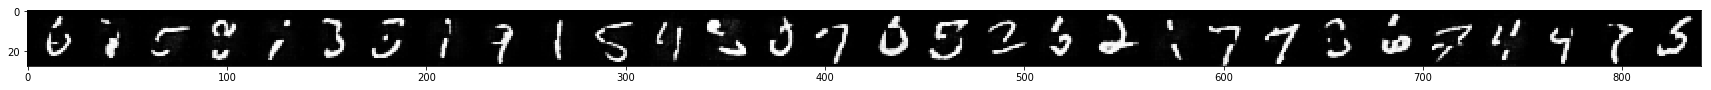

In [10]:
# Testing
# Encode and decode images from test set and visualize their reconstruction.
n = 30
canvas_input = np.empty((28, 28 * n))
canvas_hole = np.empty((28, 28 * n))
canvas_recon = np.empty((28, 28 * n))
for j in range(3):
    for i in range(n):
        # MNIST test set
        batch_x, _ = mnist.test.next_batch(100)
        input_image = batch_x
        hole_images = put_hole(batch_x.reshape(-1, 28, 28, 1)) #create the holes
        # TO DO: Implement to fill the hole images, you can reshape the hole_images
        # You can reshape the hole_images to fit the shape of the placeholder X
        # define the decoder in the decoder part
        g = sess.run(decoder, feed_dict={X: hole_images})

        canvas_input[0:28, i * 28:(i + 1) * 28] = input_image[i].reshape([28, 28])
        canvas_hole[0:28, i * 28:(i + 1) * 28] = hole_images[i].reshape([28, 28])
        canvas_recon[0:28, i * 28:(i + 1) * 28] = g[i].reshape([28, 28])

    print("Input Images")     
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_input, origin="upper", cmap="gray")
    plt.show()

    print("Hole Images")     
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_hole, origin="upper", cmap="gray")
    plt.show()

    print("Reconstructed Images")
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_recon, origin="upper", cmap="gray")
    plt.show()

    out_image = np.concatenate((canvas_input, canvas_hole, canvas_recon), axis=0)
    plt.imsave('result{}.png'.format(j), out_image, cmap="gray")